In [17]:
from datasets import load_dataset
from dataloader import *
from transformer import *
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
def validation(model, iterator, optimizer, criterion, device):
    # set model into evaluation mode
    model.eval()

    # validation
    # loss, metrics for current epoch
    val_epoch_loss = 0
    val_epoch_accuracy = 0

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)

            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy

            val_epoch_loss += loss.item()
            val_epoch_accuracy += accuracy

    # return mean loss w.r.t. batches
    return val_epoch_loss / len(iterator), val_epoch_accuracy / len(iterator)

def plot_training(history, marker=None):
    # put everything on cpu
    for key, value in history.items():
        history[key] = [element.cpu() if isinstance(element, torch.Tensor) else element for element in value]

    plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training loss')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_loss'] + history['val_loss'])
        y_max = max(history['train_loss'] + history['val_loss'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training metric')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_acc'] + history['val_acc'])
        y_max = max(history['train_acc'] + history['val_acc'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.show()

def train_save_best(model, iterator, valid_iter, optimizer, criterion, epoch, clip, device):

    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': [],
               'learning_rate': []}
    best_model = None
    best_model_score = 1e9
    best_model_epoch = 0

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)
        
        scheduler.step(val_loss)

        # save data
        with torch.no_grad():
            current_lr = optimizer.param_groups[0]['lr']

            for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc, current_lr]):
                history[key].append(value)

            # save best model (w.r.t validation loss)
            if val_loss < best_model_score:
                best_model = model.state_dict()
                best_model_score = val_loss
                best_model_epoch = e

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}, \
              Learning Rate : {optimizer.param_groups[0]['lr'] :.4f}")

    # print training curve
    plot_training(history, marker=best_model_epoch)

    return history, best_model, best_model_score


## Import Data

In [10]:
# init
tokenizer = Tokenizer()
loader = DataLoader(tokenize = tokenizer.tokenize)

dataset = load_dataset("sentiment140")
data_train = pd.DataFrame({'text': dataset['train']['text'], 'sentiment' : dataset['train']['sentiment']})
data_test = pd.DataFrame({'text': dataset['test']['text'], 'sentiment' : dataset['test']['sentiment']})

concat = [data_train, data_test]
data = pd.concat(concat)
data = data.sample(n = 70000, random_state = 42)
# convert string label to binary (int) label (positive:1, negative:0)
data["sentiment"] = data['sentiment'].apply(lambda x : int(x == 4))
# train, test, val split
train_A, valid_A, test_A = loader.make_dataset(data)

dataset = load_dataset("sst2")

data_train = pd.DataFrame({'text': dataset['train']['sentence'], 'sentiment' : dataset['train']['label']})
data_test = pd.DataFrame({'text': dataset['test']['sentence'], 'sentiment' : dataset['test']['label']})
data_val = pd.DataFrame({'text': dataset['validation']['sentence'], 'sentiment' : dataset['validation']['label']})

concat = [data_train, data_test, data_val]
data = pd.concat(concat)
data = data.sample(n = len(data), random_state = 42)
# convert string label to binary (int) label (positive:1, negative:0)
data["sentiment"] = data['sentiment'].apply(lambda x : int(x == 1))
# train, test, val split
train_B, valid_B, test_B = loader.make_dataset(data)

vocab = loader.get_vocab(pd.concat([train_A, train_B], ignore_index=True).iloc[:, 0])

train_iter_A, valid_iter_A, test_iter_A = loader.make_iter(train_A, valid_A, test_A,
                                                     batch_size=512,
                                                     device=device,
                                                     vocab=vocab)

train_iter_B, valid_iter_B, test_iter_B = loader.make_iter(train_B, valid_B, test_B,
                                                     batch_size=512,
                                                     device=device,
                                                     vocab=vocab)

# NLP stuff
pad_idx = vocab['__PAD__']
voc_size = len(vocab)
print("Vocabulary Size : ", voc_size)

dataset initializing start


Found cached dataset sentiment140 (C:/Users/atace/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)
100%|██████████| 2/2 [00:00<00:00, 26.65it/s]


Length of data after first step of preprocessing:  70000
Tokenizing the data...
Length of the data :  70000
1


Found cached dataset sst2 (C:/Users/atace/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
100%|██████████| 3/3 [00:00<00:00, 497.09it/s]


Length of data after first step of preprocessing:  70042
Tokenizing the data...
Length of the data :  70042
1
text         [[CLS], wicked, ##bit, ##ch, it, is, because, ...
sentiment                                                    1
len                                                         15
Name: 1102814, dtype: object


100%|██████████| 7000/7000 [00:00<00:00, 11058.72it/s]


dataset initializing done
text         [[CLS], elegant, ##ly, appointed, [SEP]]
sentiment                                           1
len                                                 5
Name: 60611, dtype: object


100%|██████████| 7005/7005 [00:00<00:00, 10210.21it/s]


dataset initializing done
Vocabulary Size :  20369


In [11]:
# Creating the embedding matrix
embedding = torch.nn.Embedding(voc_size, 16)

  0%|          | 0/110 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_10596/1135373371.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 110/110 [05:24<00:00,  2.95s/it]
C:\Users\atace\AppData\Local\Temp/ipykernel_10596/1135373371.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.8056               Validation Loss: 0.6763               Train acc: 0.5076,               Val acc: 0.5192,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:05<00:00,  3.33s/it]


Epoch: 2  Train Loss: 0.5816               Validation Loss: 0.5361               Train acc: 0.6886,               Val acc: 0.7398,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:17<00:00,  3.43s/it]


Epoch: 3  Train Loss: 0.4354               Validation Loss: 0.5524               Train acc: 0.8033,               Val acc: 0.7377,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:12<00:00,  3.39s/it]


Epoch: 4  Train Loss: 0.4008               Validation Loss: 0.5895               Train acc: 0.8225,               Val acc: 0.7321,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:09<00:00,  3.36s/it]


Epoch: 5  Train Loss: 0.3779               Validation Loss: 0.5471               Train acc: 0.8351,               Val acc: 0.7533,               Learning Rate : 0.0010


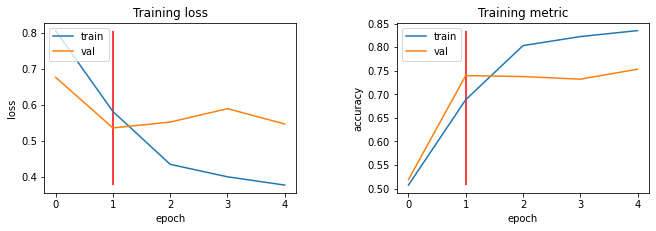

Wall time: 32min 9s


In [18]:
%%time
# train model A
modelA = TransformerClassifier(embedding=embedding,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 2,
                              n_layers = 1,
                              drop_prob = 0.7,
                              device = device)
modelA = modelA.to(device) # put on CPU/GPU

optA = torch.optim.Adam(modelA.parameters(), lr=0.001)
loss_fnA = nn.CrossEntropyLoss()


epochs = 5

historyA, best_modelA, best_model_scoreA = train_save_best(model=modelA,
                                                            iterator=train_iter_A,
                                                            valid_iter=valid_iter_A,
                                                            optimizer=optA,
                                                            criterion=loss_fnA,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelA, './Models/modelA_sentiment140_256')

# save history
with open('./Models/history_modelA_sentiment140_256.txt', 'w') as dat:
    dat.write(str(historyA))

  0%|          | 0/110 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_10596/1135373371.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 110/110 [05:29<00:00,  3.00s/it]
C:\Users\atace\AppData\Local\Temp/ipykernel_10596/1135373371.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.7946               Validation Loss: 0.6823               Train acc: 0.5194,               Val acc: 0.5531,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:27<00:00,  3.52s/it]


Epoch: 2  Train Loss: 0.5886               Validation Loss: 0.5083               Train acc: 0.6718,               Val acc: 0.7323,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:52<00:00,  3.75s/it]


Epoch: 3  Train Loss: 0.4421               Validation Loss: 0.4590               Train acc: 0.7961,               Val acc: 0.7933,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:55<00:00,  3.78s/it]


Epoch: 4  Train Loss: 0.3581               Validation Loss: 0.4086               Train acc: 0.8502,               Val acc: 0.8320,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:57<00:00,  3.79s/it]


Epoch: 5  Train Loss: 0.3341               Validation Loss: 0.3594               Train acc: 0.8634,               Val acc: 0.8550,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:33<00:00,  3.58s/it]


Epoch: 6  Train Loss: 0.2951               Validation Loss: 0.3641               Train acc: 0.8834,               Val acc: 0.8555,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:36<00:00,  3.61s/it]


Epoch: 7  Train Loss: 0.2947               Validation Loss: 0.3806               Train acc: 0.8823,               Val acc: 0.8483,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:34<00:00,  3.58s/it]


Epoch: 8  Train Loss: 0.2815               Validation Loss: 0.3452               Train acc: 0.8883,               Val acc: 0.8673,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:43<00:00,  3.67s/it]


Epoch: 9  Train Loss: 0.2661               Validation Loss: 0.3993               Train acc: 0.8955,               Val acc: 0.8391,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:49<00:00,  3.72s/it]


Epoch: 10  Train Loss: 0.2602               Validation Loss: 0.3400               Train acc: 0.8984,               Val acc: 0.8689,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:35<00:00,  3.60s/it]


Epoch: 11  Train Loss: 0.2491               Validation Loss: 0.3365               Train acc: 0.9046,               Val acc: 0.8721,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:39<00:00,  3.63s/it]


Epoch: 12  Train Loss: 0.2407               Validation Loss: 0.3347               Train acc: 0.9083,               Val acc: 0.8716,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:39<00:00,  3.63s/it]


Epoch: 13  Train Loss: 0.2399               Validation Loss: 0.3393               Train acc: 0.9073,               Val acc: 0.8739,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:35<00:00,  3.60s/it]


Epoch: 14  Train Loss: 0.2307               Validation Loss: 0.3660               Train acc: 0.9122,               Val acc: 0.8649,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:36<00:00,  3.60s/it]


Epoch: 15  Train Loss: 0.2233               Validation Loss: 0.3310               Train acc: 0.9149,               Val acc: 0.8781,               Learning Rate : 0.0010


100%|██████████| 110/110 [07:45<00:00,  4.23s/it]


Epoch: 16  Train Loss: 0.2197               Validation Loss: 0.3397               Train acc: 0.9168,               Val acc: 0.8755,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:23<00:00,  3.49s/it]


Epoch: 17  Train Loss: 0.2091               Validation Loss: 0.3372               Train acc: 0.9214,               Val acc: 0.8765,               Learning Rate : 0.0010


100%|██████████| 110/110 [07:17<00:00,  3.98s/it]


Epoch: 18  Train Loss: 0.2041               Validation Loss: 0.3378               Train acc: 0.9244,               Val acc: 0.8804,               Learning Rate : 0.0010


100%|██████████| 110/110 [06:40<00:00,  3.64s/it]


Epoch: 19  Train Loss: 0.1977               Validation Loss: 0.3369               Train acc: 0.9270,               Val acc: 0.8819,               Learning Rate : 0.0010


100%|██████████| 110/110 [08:23<00:00,  4.58s/it]


Epoch: 20  Train Loss: 0.1904               Validation Loss: 0.3378               Train acc: 0.9301,               Val acc: 0.8815,               Learning Rate : 0.0010


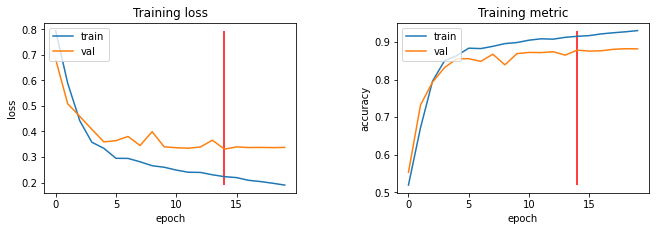

Wall time: 2h 24min 17s


In [21]:
%%time
# train model B
modelB = TransformerClassifier(embedding=embedding,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 2,
                              n_layers = 1,
                              drop_prob = 0.7,
                              device = device)
modelB = modelB.to(device) # put on CPU/GPU

optB = torch.optim.Adam(modelB.parameters(), lr=0.001)
loss_fnB = nn.CrossEntropyLoss()


epochs = 20

historyB, best_modelB, best_model_scoreB = train_save_best(model=modelB,
                                                            iterator=train_iter_B,
                                                            valid_iter=valid_iter_B,
                                                            optimizer=optB,
                                                            criterion=loss_fnB,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelA, './Models/modelB_sentiment140_256')

# save history
with open('./Models/history_modelB_sentiment140_256.txt', 'w') as dat:
    dat.write(str(historyA))

In [22]:
torch.save(embedding, "Models\embedding_16_trained_downstream.pt")